# Simulate RN + GWB in pulsars

In [1]:
from pta_replicator_main.pta_replicator.simulate import load_from_directories
from pta_replicator_main.pta_replicator.simulate import make_ideal
from pta_replicator_main.pta_replicator.white_noise import add_measurement_noise
from pta_replicator_main.pta_replicator.red_noise import add_red_noise, add_gwb
from pta_replicator_main.pta_replicator.deterministic import add_cgw

import pickle
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from random import sample, seed

import params_injected
from pulsar_phase import get_psr_phase

In [2]:
pardir = 'partim/par'
timdir = 'partim/tim'
num_psrs = params_injected.num_psrs
# psrs = load_from_directories(pardir, timdir, num_psrs=num_psrs)
psrs_full = load_from_directories(pardir, timdir, num_psrs=50)
seed(0)
psrs = sample(psrs_full, k=num_psrs)

2025-08-01 10:58:38.031 | DEBUG    | pint.toa:__init__:1358 - No pulse number flags found in the TOAs
2025-08-01 10:58:38.032 | DEBUG    | pint.toa:apply_clock_corrections:2200 - Applying clock corrections (include_gps = True, include_bipm = True)
2025-08-01 10:58:38.041 | INFO     | pint.observatory:gps_correction:210 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-01 10:58:38.042 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2025-08-01 10:58:38.046 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-08-01 10:58:38.049 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/Users/aidengundersen/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2025-08-01 10:58:38.068 | INFO     | pint.

In [3]:
# add signals and noise
psr_phases = np.zeros(num_psrs)
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    # add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr,
                          efac=params_injected.efac_inj, 
                          seed=params_injected.efac_seed + ii)

    ## add red noise
    if params_injected.rn_model:
        add_red_noise(psr,
                    log10_amplitude=params_injected.RN_logamps_inj[ii],
                    spectral_index=params_injected.RN_gammas_inj[ii],
                    components=params_injected.num_modes,
                    seed=params_injected.RN_seed + ii)
    
    # ## add continuous wave
    # if params_injected.cw_model:
    #     ent_psr = psr.to_enterprise()
    #     psr_dist = ent_psr.pdist[0]
    #     psr_phase = get_psr_phase(params_injected.CW_params_inj, ent_psr.pos, psr_dist)
    #     psr_phases[ii] = psr_phase
    #     psr_params = np.array([psr_dist, psr_phase])
    #     add_cgw(psr, params_injected.CW_params_inj, psr_params, ent_psr.toas, ent_psr.pos)

    print(ii, psr.name)

2025-08-01 10:58:49.682 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-01 10:58:49.683 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-01 10:58:49.684 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-01 10:58:49.684 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-01 10:58:49.701 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-01 10:58:49.702 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-01 10:58:49.703 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-01 10:58:49.703 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-01 10:58:49.704 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

0 J1312+0051


In [4]:
# if params_injected.gwb_model:
#         add_gwb(psrs,
#                 log10_amplitude=params_injected.GWB_logamp_inj,
#                 spectral_index=params_injected.GWB_gamma_inj,
#                 seed=params_injected.GWB_seed)

In [5]:
# fit timing model
for psr in psrs:
    print(psr.name)
    psr.fit()

2025-08-01 10:58:50.211 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1312+0051


2025-08-01 10:58:51.164 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.00021510398866875224


J1312+0051


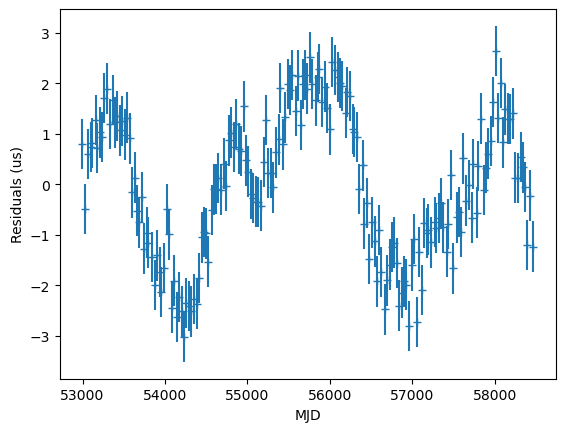

In [6]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()

In [7]:
# convert to enterprise type pulsars
ent_psrs = []
for psr in psrs:
    ent_psrs.append(psr.to_enterprise())

2025-08-01 10:58:51.740 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-01 10:58:51.758 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-01 10:58:51.759 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.


In [8]:
# save data
Ms = np.array([ent_psr.Mmat for ent_psr in ent_psrs])
Ns = np.array([np.diag(ent_psr.toaerrs**2.) for ent_psr in ent_psrs])
toas = np.array([ent_psr.toas for ent_psr in ent_psrs])
residuals = np.array([ent_psr.residuals for ent_psr in ent_psrs])
psr_pos = np.array([ent_psr.pos for ent_psr in ent_psrs])
psr_names = np.array([ent_psr.name for ent_psr in ent_psrs])
psr_dists = np.array([[psr.pdist[0], psr.pdist[1]] for psr in ent_psrs]).T
np.save('data/Ms.npy', Ms)
np.save('data/Ns.npy', Ns)
np.save('data/toas.npy', toas)
np.save('data/residuals.npy', residuals)
np.save('data/psr_pos.npy', psr_pos)
np.save('data/psr_names.npy', psr_names)
np.save('data/psr_dists.npy', psr_dists)
np.save('data/psr_phases.npy', psr_phases)

In [9]:
# save Enterprise pulsar objects
with open('enterprise_pulsars.pkl', 'wb') as f:
    pickle.dump(ent_psrs, f)

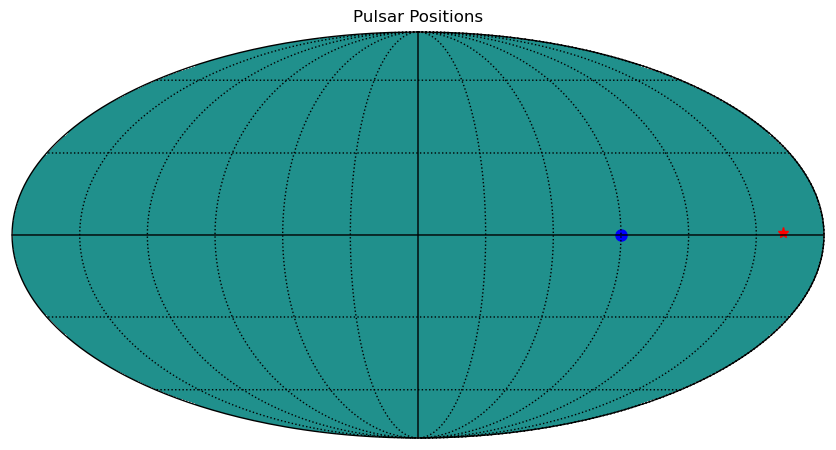

In [10]:
# plot pulsar positions
theta_psr = np.arccos(psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.arctan2(psr_pos[:, 1], psr_pos[:, 0])  # atan2(y, x)
phi_psr = np.mod(phi_psr, 2 * np.pi)


# Convert to HEALPix map
nside = 64
npix = hp.nside2npix(nside)

# Plot
hp.mollview(np.zeros(hp.nside2npix(64)), title="Pulsar Positions", cbar=False)
hp.projplot(theta_psr, phi_psr, 'r*', markersize=8)
hp.projplot(params_injected.gwtheta_inj, params_injected.gwphi_inj, 'bo', markersize=8)
hp.graticule()
plt.show()